In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

In [9]:
# Load the training data
train_data = pd.read_csv('data/train.csv')

# Split data into features and target
X = train_data['Text']
y = train_data['Verdict']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_val.shape)

print("Original class distribution:")
class_counts = train_data['Verdict'].value_counts().sort_index()
print(f"Class -1: {class_counts.get(-1, 0)} samples")
print(f"Class 0: {class_counts.get(0, 0)} samples")
print(f"Class 1: {class_counts.get(1, 0)} samples")

Train shape: (18000,) Test shape: (4501,)
Original class distribution:
Class -1: 14685 samples
Class 0: 2403 samples
Class 1: 5413 samples


In [25]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
classes_weights

array([0.51024747, 1.38248848, 0.51024747, ..., 0.51024747, 1.38248848,
       1.38248848])

In [12]:
from sklearn.metrics import confusion_matrix, f1_score

tfidf = TfidfVectorizer(
    min_df=3,
    max_df=0.9,
    ngram_range=(1, 2),
    lowercase=True,
    stop_words='english',
    max_features=5000
)


In [13]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)


In [71]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_tfidf_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)
smote_class_counts = y_train_resampled.value_counts().sort_index()
print(f"Class -1: {smote_class_counts.get(-1, 0)} samples")
print(f"Class 0: {smote_class_counts.get(0, 0)} samples")
print(f"Class 1: {smote_class_counts.get(1, 0)} samples")

Class -1: 11759 samples
Class 0: 11759 samples
Class 1: 11759 samples


In [72]:

def macro_f1(y_true, y_pred_prob):
    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

    return f1_score(y_true, y_pred, average='macro')


xgb_classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=4,  # Increase to prevent overfitting on minority classes
    gamma=0.1,           # Minimum loss reduction for a split
    subsample=0.8,       # Fraction of samples used for tree building
    colsample_bytree=0.8, # Fraction of features used for tree building
    random_state=42,
    reg_alpha=0.01,
    scale_pos_weight=None,
    # use_label_encoder=False,
    objective='multi:softprob',
    eval_metric=macro_f1,
    # early_stopping_rounds=100,
)
xgb_classifier.fit(
    X_train_tfidf, 
    y_train + 1, 
    # sample_weight=classes_weights,
    eval_set=[(X_train_tfidf_resampled, y_train_resampled + 1), (X_val_tfidf, y_val + 1)],
    verbose=True,
)


[0]	validation_0-mlogloss:1.08761	validation_0-macro_f1:0.32633	validation_1-mlogloss:1.05198	validation_1-macro_f1:0.43856
[1]	validation_0-mlogloss:1.08112	validation_0-macro_f1:0.32930	validation_1-mlogloss:1.01270	validation_1-macro_f1:0.44488
[2]	validation_0-mlogloss:1.07741	validation_0-macro_f1:0.32020	validation_1-mlogloss:0.97942	validation_1-macro_f1:0.43730
[3]	validation_0-mlogloss:1.07570	validation_0-macro_f1:0.33027	validation_1-mlogloss:0.95113	validation_1-macro_f1:0.44695
[4]	validation_0-mlogloss:1.07555	validation_0-macro_f1:0.32283	validation_1-mlogloss:0.92676	validation_1-macro_f1:0.43942
[5]	validation_0-mlogloss:1.07711	validation_0-macro_f1:0.32138	validation_1-mlogloss:0.90563	validation_1-macro_f1:0.43445
[6]	validation_0-mlogloss:1.07880	validation_0-macro_f1:0.32410	validation_1-mlogloss:0.88723	validation_1-macro_f1:0.43950
[7]	validation_0-mlogloss:1.08158	validation_0-macro_f1:0.32223	validation_1-mlogloss:0.87141	validation_1-macro_f1:0.43601
[8]	vali

XGBClassifier(alpha=0.01, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function macro_f1 at 0x366794400>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1500,
              n_jobs=None, num_parallel_tree=None, ...)

In [73]:
feature_importance = xgb_classifier.feature_importances_
feature_names = tfidf.get_feature_names_out()

# Get top 20 features
top_indices = np.argsort(feature_importance)[-20:]
top_features = [(feature_names[i], feature_importance[i]) for i in top_indices]
top_features.reverse()  # Show highest importance first

print("\nTop 20 important features:")
for feature, importance in top_features:
    print(f"{feature}: {importance:.4f}")



Top 20 important features:
percent: 0.0102
billion: 0.0075
million: 0.0063
000: 0.0056
trillion: 0.0037
said: 0.0035
want: 0.0032
believe: 0.0032
think: 0.0031
year: 0.0030
dollars: 0.0029
indicated: 0.0027
companies: 0.0026
doubled: 0.0026
let: 0.0025
50: 0.0025
named: 0.0025
years: 0.0024
world war: 0.0024
loans: 0.0023


In [74]:
y_pred = xgb_classifier.predict(X_val_tfidf)
print(f"Macro F1 Score: {f1_score(y_val, y_pred - 1, average='macro'):.4f}")



Macro F1 Score: 0.5701


Confusion matrix saved as 'confusion_matrix.png'


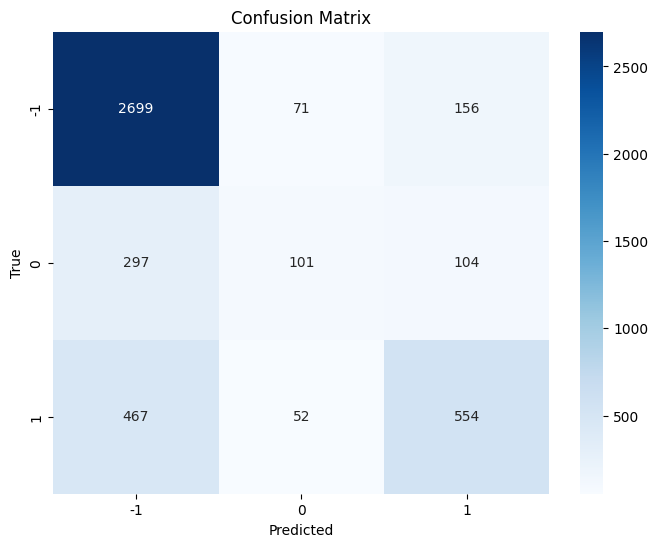

In [75]:
from matplotlib import pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_val, y_pred-1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

In [62]:
import pickle


pipeline = Pipeline([
    ('tfidf', tfidf),
    ('classifier', xgb_classifier)
])

model_path = 'models/xgboost_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(pipeline, f)

In [63]:
def load_model(model_path):
    with open(model_path, 'rb') as f:
        loaded_model = pickle.load(f)
    return loaded_model

loaded_model = load_model(model_path)
y_pred = loaded_model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred-1))
print(classification_report(y_val, y_pred-1))
print("f1 score(macro):", f1_score(y_val, y_pred-1, average='macro'))

Accuracy: 0.6822928238169296
              precision    recall  f1-score   support

          -1       0.85      0.76      0.80      2926
           0       0.28      0.45      0.35       502
           1       0.58      0.59      0.59      1073

    accuracy                           0.68      4501
   macro avg       0.57      0.60      0.58      4501
weighted avg       0.72      0.68      0.70      4501

f1 score(macro): 0.5771191212633028


In [65]:

# Function to make predictions on test data
def predict_test_data(model_path, test_path, output_path):
    # Load the model and test data
    model = load_model(model_path)
    test_data = pd.read_csv(test_path)
    
    # Make predictions
    predictions = model.predict(test_data['Text'])
    
    # Create output DataFrame
    output_df = pd.DataFrame({
        'Sentence_id': test_data['Sentence_id'],
        'Verdict': predictions - 1
    })
    
    # Save to CSV
    output_df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")


print("\nMaking predictions on test data...")
predict_test_data(model_path, 'data/test.csv', 'data/xgboost_predictions.csv')


Making predictions on test data...
Predictions saved to data/xgboost_predictions.csv
